In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Markov Models')

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You

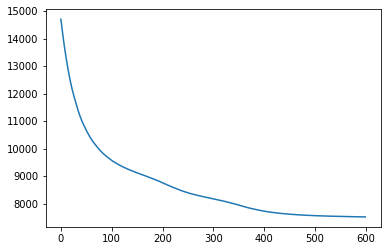

LL for fitted params: 7515.5957
LL for actual params: 7462.6655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:210: RuntimeWarning: divide by zero encountered in log


In [3]:
import wave
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
MVN = tf.contrib.distributions.MultivariateNormalDiag
from generate_hmmc_data import get_signals, big_init


class HMM:
    def __init__(self, M, K, D):
        self.M = M # number of hidden states
        self.K = K # number of Gaussians
        self.D = D # Gaussian dimensionality

    def set_session(self, session):
        self.session = session

    def init_random(self, X):
        pi0 = np.ones(self.M).astype(np.float32) # initial state distribution
        A0 = np.random.randn(self.M, self.M).astype(np.float32) # state transition matrix
        R0 = np.ones((self.M, self.K)).astype(np.float32) # mixture proportions
        # mu0 = np.random.randn(self.M, self.K, self.D).astype(np.float32)

        mu0 = np.zeros((self.M, self.K, self.D))
        for j in range(self.M):
            for k in range(self.K):
                n = np.random.randint(X.shape[0])
                t = np.random.randint(X.shape[1])
                mu0[j,k] = X[n,t]
        mu0 = mu0.astype(np.float32)

        sigma0 = np.random.randn(self.M, self.K, self.D).astype(np.float32)
        self.build(pi0, A0, R0, mu0, sigma0)

    def build(self, preSoftmaxPi, preSoftmaxA, preSoftmaxR, mu, logSigma):
        self.preSoftmaxPi = tf.Variable(preSoftmaxPi)
        self.preSoftmaxA = tf.Variable(preSoftmaxA)
        self.preSoftmaxR = tf.Variable(preSoftmaxR)
        self.mu = tf.Variable(mu)
        self.logSigma = tf.Variable(logSigma)


        pi = tf.nn.softmax(self.preSoftmaxPi)
        A = tf.nn.softmax(self.preSoftmaxA)
        R = tf.nn.softmax(self.preSoftmaxR)
        sigma = tf.exp(self.logSigma)


        # X will be TxD
        self.tfx = tf.placeholder(tf.float32, shape=(None, self.D), name='X')


        # first we need to calculate B
        # B[j,t] = probability of X being in state j at time t
        #        = Gaussian mixture P( x(t) | mu(j), sigma(j) )
        # idea: first calculate components and sum
        # note: we can use a for loop because M and K are not TF variables
        self.mvns = []
        for j in range(self.M):
            self.mvns.append([])
            for k in range(self.K):
                self.mvns[j].append(
                    MVN(self.mu[j,k], sigma[j,k])
                )

        # note: we can use a for loop because M and K are not TF variables
        B = []
        for j in range(self.M):
            components = []
            for k in range(self.K):
                components.append(
                    self.mvns[j][k].prob(self.tfx)
                )

            # why?
            # because we can stack a list of tensors
            # but not a list of lists of tensors

            # components[j] will be K x T
            # we now want to multiply by the mixture probability (R)
            # result is M x T
            # which gives us P( X(t) | state j )
            components = tf.stack(components)
            R_j = tf.reshape(R[j], [1, self.K])
            p_x_t_j = tf.matmul(R_j, components)

            # now components[j] is just 1 x T --> T
            components = tf.reshape(p_x_t_j, [-1])

            # now append it to B
            B.append(components)
            

        # should now be M x T
        B = tf.stack(B)

        # we should make it T x M since scan will loop through first index
        B = tf.transpose(B, [1, 0])



        # now perform the forward algorithm
        def recurrence(old_a_old_s, B_t):
            old_a = tf.reshape(old_a_old_s[0], (1, self.M))
            a = tf.matmul(old_a, A) * B_t
            a = tf.reshape(a, (self.M,))
            s = tf.reduce_sum(a)
            return (a / s), s

        alpha, scale = tf.scan(
            fn=recurrence,
            elems=B[1:],
            initializer=(pi*B[0], np.float32(1.0)),
        )
        # note: tensorflow is very strict about what types you pass in to initializer!
        #   - cannot be list, must be tuple
        #   - cannot be 1 (int), must be float32

        self.cost_op = -tf.reduce_sum(tf.log(scale))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost_op)

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxR, mu, logSigma):
        # assume build has already been called
        # we just assign these new variables
        op1 = self.preSoftmaxPi.assign(preSoftmaxPi)
        op2 = self.preSoftmaxA.assign(preSoftmaxA)
        op3 = self.preSoftmaxR.assign(preSoftmaxR)
        op4 = self.mu.assign(mu)
        op5 = self.logSigma.assign(logSigma)
        self.session.run([op1, op2, op3, op4, op5])
    
    def fit(self, X, max_iter=10):
        # train the HMM model using stochastic gradient descent

        N = len(X)
        print("number of train samples:", N)

        costs = []
        for it in range(max_iter):
            if it % 1 == 0:
                print("it:", it)
            
            for n in range(N):
                # this would of course be much faster if we didn't do this on
                # every iteration of the loop
                c = self.get_cost_multi(X).sum()
                costs.append(c)
                self.session.run(self.train_op, feed_dict={self.tfx: X[n]})

        plt.plot(costs)
        plt.show()

    def get_cost(self, x):
        return self.session.run(self.cost_op, feed_dict={self.tfx: x})

    def get_cost_multi(self, X):
        return np.array([self.get_cost(x) for x in X])


def real_signal():
    spf = wave.open('helloworld.wav', 'r')

    #Extract Raw Audio from Wav File
    # If you right-click on the file and go to "Get Info", you can see:
    # sampling rate = 16000 Hz
    # bits per sample = 16
    # The first is quantization in time
    # The second is quantization in amplitude
    # We also do this for images!
    # 2^16 = 65536 is how many different sound levels we have
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    T = len(signal)
    signal = (signal - signal.mean()) / signal.std()

    # signal needs to be of shape N x T(n) x D
    signals = signal.reshape(1, T, 1)

    hmm = HMM(3, 3, 1)
    hmm.init_random(signals)

    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    hmm.set_session(session)

    hmm.fit(signals, max_iter=30)


def fake_signal():
    signals = get_signals()
    # assume all signals are same length
    signals = np.array(signals)
    hmm = HMM(5, 3, signals[0].shape[1]) # M, K, D
    hmm.init_random(signals)

    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    hmm.set_session(session)

    hmm.fit(signals, max_iter=30)
    L = hmm.get_cost_multi(signals).sum()
    print("LL for fitted params:", L)

    # test in actual params
    _, _, _, pi, A, R, mu, sigma = big_init()

    # turn these into their "pre-softmax" forms
    pi = np.log(pi)
    A = np.log(A)
    R = np.log(R)
    M, K, D, _ = sigma.shape # need to convert full cov into diag cov
    logSigma = np.zeros((M, K, D))
    for j in range(M):
        for k in range(D):
            logSigma[j,k] = np.log(np.diag(sigma[j,k]))

    hmm.set(pi, A, R, mu, logSigma)
    L = hmm.get_cost_multi(signals).sum()
    print("LL for actual params:", L)

if __name__ == '__main__':
    # real_signal()
    fake_signal()